In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import multiprocessing

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import jax
import pandas as pd
import numpy as np
import numpyro

from hbmep.config import Config
from hbmep.model import Baseline
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()


In [2]:
root_path = Path(os.getcwd()).parent.parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/rcml/fcr.toml")

config = Config(toml_path=toml_path)

model = Baseline(config=config)

df = pd.read_csv(model.csv_path)

ind = df.pulse_amplitude.isin([0])
df = df[~ind].reset_index(drop=True).copy()

""" Process """
df, encoder_dict = model.load(df=df)


2023-08-25 12:47:46,752 - hbmep.config - INFO - Verifying configuration ...
2023-08-25 12:47:46,752 - hbmep.config - INFO - Success!
2023-08-25 12:47:46,767 - hbmep.model.baseline - INFO - Initialized model with baseline link
2023-08-25 12:47:46,783 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/J_RCML_000/fcr
2023-08-25 12:47:46,783 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/J_RCML_000/fcr
2023-08-25 12:47:46,784 - hbmep.dataset.core - INFO - Processing data ...
2023-08-25 12:47:46,786 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [3]:
combinations = model._make_combinations(df=df, columns=model.combination_columns)
combinations_inv = [
    (encoder_dict[model.subject].inverse_transform(np.array([c[0]]))[0], encoder_dict[model.features[0]].inverse_transform(np.array([c[1]]))[0]) for c in combinations
]

conditions = sorted(df[model.features[0]].unique().tolist())

""" Fix subject colors """
subjects = df[model.subject].unique().tolist()
n_subjects = len(subjects)

colors = iter(plt.cm.rainbow(np.linspace(0, 1, n_subjects)))
colors_dict = {}

for sub in subjects:
    color = next(colors)
    colors_dict[sub] = color

In [4]:
muscles = ["deltoid", "biceps", "triceps", "ecr", "fcr", "adm"]
a = None

for muscle in muscles:
    a_muscle = None

    for i, c in enumerate(combinations):
        c_inv = combinations_inv[i]
        src = f"/home/vishu/repos/hbmep-paper/reports/J_RCML_000/{muscle}/iterative/{c_inv[0]}/{c_inv[1]}"

        mcmc = az.from_netcdf(os.path.join(src, "mcmc.nc"))["posterior"]
        a_temp = mcmc[site.a].to_numpy()
        a_temp = a_temp[..., 0, 0, 0]
        a_temp = a_temp[..., None]

        if a_muscle is None:
            a_muscle = a_temp
        else:
            a_muscle = np.concatenate((a_muscle, a_temp), axis=-1)

    a_muscle = a_muscle[..., None]

    if a is None:
        a = a_muscle
    else:
        a = np.concatenate((a, a_muscle), axis=-1)

In [5]:
a.shape


(4, 6000, 150, 6)

In [6]:
# t = az.summary({"a": a})

In [7]:
a = a.reshape(-1, *a.shape[2:])
a = np.array(jax.random.permutation(model.rng_key, x=a, axis=0, independent=True))
a_map = a.mean(axis=0)


In [8]:
a.shape

(24000, 150, 6)

In [9]:
a_map.shape

(150, 6)

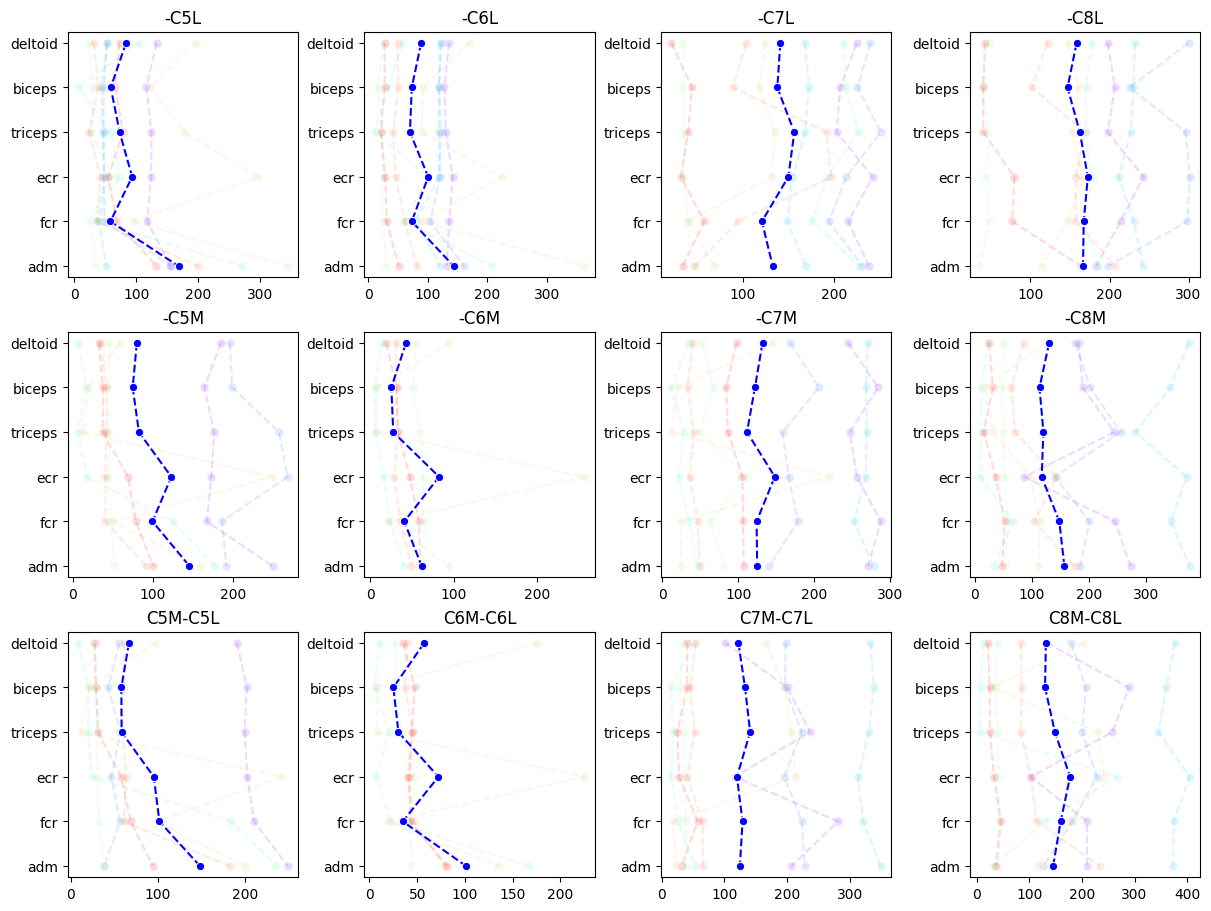

In [10]:
mat = a_map

conditions_inv = [
    '-C5L', '-C6L', '-C7L', '-C8L',
    '-C5M', '-C6M', '-C7M', '-C8M',
    'C5M-C5L', 'C6M-C6L', 'C7M-C7L', 'C8M-C8L'
]

nrows = 3
ncols = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 3 * nrows), constrained_layout=True)

for i, pos_inv in enumerate(conditions_inv):
    ax = axes[i // ncols, i % ncols]
    pos = encoder_dict[model.features[0]].transform(np.array([pos_inv]))[0]
    curr_combinations = [(i, c) for i, c in enumerate(combinations) if c[1] == pos]
    curr_combinations = sorted(curr_combinations, key=lambda x: x[1][0])

    for v in curr_combinations:
        sns.lineplot(x=mat[v[0], :], y=muscles, marker="o", linestyle="dashed", alpha=.15, color=colors_dict[v[1][0]], orient="y", ax=ax)

    sns.lineplot(x=mat[[v[0] for v in curr_combinations], :].mean(axis=0), y=muscles, marker="o", linestyle="dashed", color="b", orient="y", ax=ax)
    ax.set_title(f"{pos_inv}")

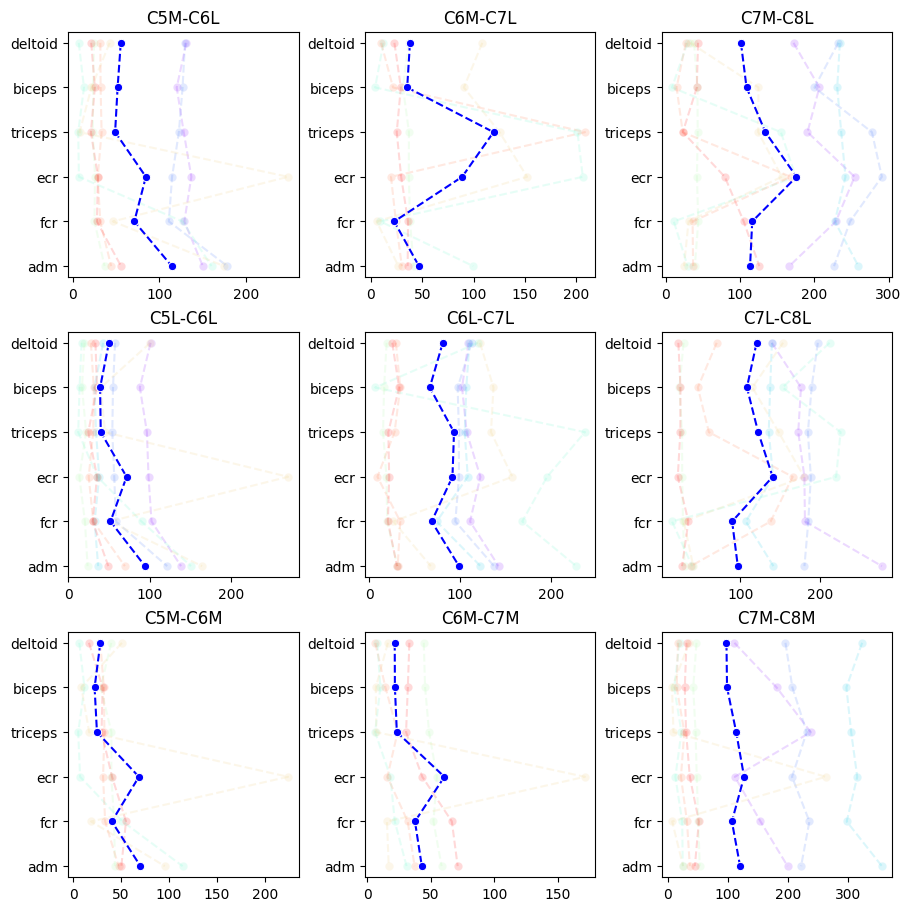

In [11]:
mat = a_map

conditions_inv = [
    'C5M-C6L', 'C6M-C7L', 'C7M-C8L',
    'C5L-C6L', 'C6L-C7L', 'C7L-C8L',
    'C5M-C6M', 'C6M-C7M', 'C7M-C8M'
]

nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 3 * nrows), constrained_layout=True)

for i, pos_inv in enumerate(conditions_inv):
    ax = axes[i // ncols, i % ncols]
    pos = encoder_dict[model.features[0]].transform(np.array([pos_inv]))[0]
    curr_combinations = [(i, c) for i, c in enumerate(combinations) if c[1] == pos]
    curr_combinations = sorted(curr_combinations, key=lambda x: x[1][0])

    for v in curr_combinations:
        sns.lineplot(x=mat[v[0], :], y=muscles, marker="o", linestyle="dashed", alpha=.15, color=colors_dict[v[1][0]], orient="y", ax=ax)

    sns.lineplot(x=mat[[v[0] for v in curr_combinations], :].mean(axis=0), y=muscles, marker="o", linestyle="dashed", color="b", orient="y", ax=ax)
    ax.set_title(f"{pos_inv}")

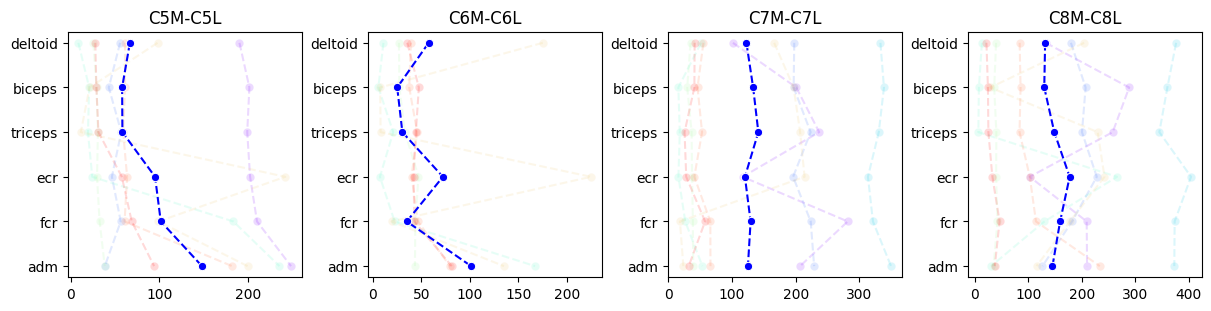

In [12]:
mat = a_map

conditions_inv = [
    'C5M-C5L', 'C6M-C6L', 'C7M-C7L', 'C8M-C8L'
]

nrows = 1
ncols = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 3 * nrows), constrained_layout=True)

for i, pos_inv in enumerate(conditions_inv[:4]):
    ax = axes[i]
    pos = encoder_dict[model.features[0]].transform(np.array([pos_inv]))[0]
    curr_combinations = [(i, c) for i, c in enumerate(combinations) if c[1] == pos]
    curr_combinations = sorted(curr_combinations, key=lambda x: x[1][0])

    for v in curr_combinations:
        sns.lineplot(x=mat[v[0], :], y=muscles, marker="o", linestyle="dashed", alpha=.15, color=colors_dict[v[1][0]], orient="y", ax=ax)

    sns.lineplot(x=mat[[v[0] for v in curr_combinations], :].mean(axis=0), y=muscles, marker="o", linestyle="dashed", color="b", orient="y", ax=ax)
    ax.set_title(f"{pos_inv}")


In [13]:
a_map.shape

(150, 6)

/tmp/ipykernel_1468246/2620251104.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels=MUSCLES, fontweight="bold", size=axis_label_size)


Text(0.5, 0.98, 'Midline Lateral')

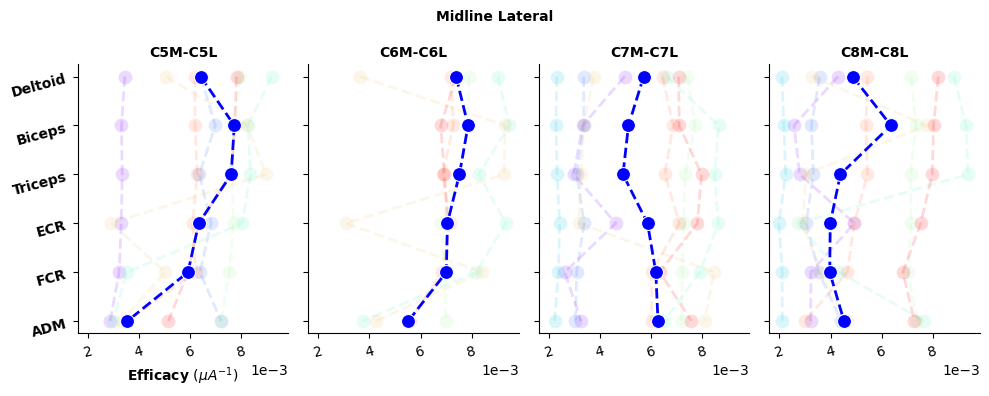

In [14]:
mat = a_map
lw = 2
ms = 10
MUSCLES = ["Deltoid", "Biceps", "Triceps", "ECR", "FCR", "ADM"]
tick_size = 10
axis_label_size = 10

conditions_inv = [
    'C5M-C5L', 'C6M-C6L', 'C7M-C7L', 'C8M-C8L'
]

nrows = 1
ncols = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5 * ncols, 4 * nrows), tight_layout=True, squeeze=False, sharey="row", sharex="row")

for i, pos_inv in enumerate(conditions_inv[:4]):
    ax = axes[0, i]
    pos = encoder_dict[model.features[0]].transform(np.array([pos_inv]))[0]
    curr_combinations = [(i, c) for i, c in enumerate(combinations) if c[1] == pos]
    curr_combinations = sorted(curr_combinations, key=lambda x: x[1][0])

    # curr_combinations = [v for v in curr_combinations if v[1][0] != 5]

    temp_mat = mat[[v[0] for v in curr_combinations], :]
    temp_mat = 1 / (temp_mat + 100)
    # temp_mat_mean = temp_mat.mean(axis=0)
    # temp_mat_mean = temp_mat.prod(axis=0) ** (1 / temp_mat.shape[0])
    temp_mat_mean = np.median(temp_mat, axis=0)

    for j, v in enumerate(curr_combinations):
        sns.lineplot(x=temp_mat[j, :], y=muscles, marker="o", markersize=ms, linestyle="dashed", alpha=.15, color=colors_dict[v[1][0]], orient="y", ax=ax, linewidth=lw)

    sns.lineplot(x=temp_mat_mean, y=muscles, marker="o", markersize=ms, linestyle="dashed", color="b", orient="y", ax=ax, linewidth=lw)
    ax.set_title(f"{pos_inv}", fontweight="bold", size=axis_label_size)

    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True,
        labelrotation=15,
        labelsize=tick_size
    )
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=True,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False,
        labelrotation=15,
        labelsize=tick_size
    )

    ax.ticklabel_format(axis='x', style='sci', scilimits=(0,2))
    # ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)

ax = axes[0, 0]
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    labelsize=tick_size
)
ax.set_xlabel("Efficacy $({µA}^{-1})$", size=axis_label_size, fontweight="bold")
ax.set_yticklabels(labels=MUSCLES, fontweight="bold", size=axis_label_size)
fig.suptitle("Midline Lateral", fontweight="bold", size=axis_label_size)

In [ ]:
arr = []

for i, pos_inv in enumerate(conditions_inv[:4]):
    pos = encoder_dict[model.features[0]].transform(np.array([pos_inv]))[0]
    curr_combinations = [(i, c) for i, c in enumerate(combinations) if c[1] == pos]
    curr_combinations = sorted(curr_combinations, key=lambda x: x[1][0])

    # curr_combinations = [v for v in curr_combinations if v[1][0] != 5]

    temp_mat = mat[[v[0] for v in curr_combinations], :]
    temp_mat = 1 / (temp_mat + 100)
    # temp_mat_mean = temp_mat.mean(axis=0)
    # temp_mat_mean = temp_mat.prod(axis=0) ** (1 / temp_mat.shape[0])
    temp_mat_mean = np.median(temp_mat, axis=0)
    arr.append(temp_mat_mean.tolist())


arr = np.array(arr)

sns.heatmap(np.corrcoef(arr), xticklabels=conditions_inv[:4], yticklabels=conditions_inv[:4], linewidths=2, square=True, annot=True, fmt=".2f", center=0, cmap="PiYG")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labeltop=True,
    labelbottom=False,
    labelrotation=15,
    labelsize=tick_size
)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=True,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=True,
    labelrotation=15,
    labelsize=tick_size
)

NameError: name 'conditions_inv' is not defined

In [ ]:
temp_mat_mean.shape

NameError: name 'temp_mat_mean' is not defined